In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
#import multiprocess as mp
from scipy.optimize import minimize
from scipy.optimize import lsq_linear
import pandas as pd
import os
import contextlib
import io
import sys
from scipy import stats
import json
import pandas as pd

from numpy import pi, cos 
from pymultinest.solve import solve
from pymultinest.run import run
from pymultinest import Analyzer
import pymultinest
import corner
import osqp
import scipy as sp
from scipy import sparse

import MulensModel as mu
from MulensModel.model import Model

%matplotlib inline

In [34]:
Y = pd.read_csv("/home/users/alpv95/khome/Yannis/data/PKS1413_135_all.dat",delimiter=",")

In [35]:
Columns = Y.columns
Obs = set(Y['# Observatory'])
freqs = set(Y[' Frequency (GHz)'])
print(Columns)
print(Obs)
print(freqs)

Index(['# Observatory', ' Frequency (GHz)', ' MJD', ' Flux (Jy)',
       ' Fluxerr (Jy)'],
      dtype='object')
{'OVRO', 'AMI-SA', 'SMA', 'OVRO (preliminary)', 'Iram3', 'Iram4', 'UMRAO', 'Metsähovi', 'Sest', 'AMI-LA', 'Kurp'}
{4.8, 37.0, 230.0, 8.0, 14.5, 15.0, 22.0, 345.0, 90.0}


In [36]:
Days = []
Fluxes = []
Flux_errs = []
titles = []

for obs in list(Obs):
    for freq in list(freqs):
        Day = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' MJD']
        Flux = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Flux (Jy)']
        Flux_err = Y.loc[(Y['# Observatory'] == obs) & (Y[' Frequency (GHz)'] == freq)][' Fluxerr (Jy)']
        
        if not Day.empty:
            Days.append(Day)
            Fluxes.append(Flux)
            Flux_errs.append(Flux_err)
            titles.append((obs,freq))

In [85]:
x = np.array([Day.to_numpy(),Flux.to_numpy(), Flux_err.to_numpy()])
np.append(x,np.array([Day.to_numpy(),Flux.to_numpy(), Flux_err.to_numpy()]), axis=1).shape

(3, 80)

In [37]:
offsets = {"UMRAO 4.8": 0,"UMRAO 8.0": 1.5,"UMRAO 14.5": 3,"OVRO 15.0": 4.5, 
           "OVRO (preliminary) 15.0": 4.5, "AMI-LA 15.0": 4.5, "AMI-SA 15.0": 4.5,
          "Metsähovi 22.0": 4.5, "Metsähovi 37.0": 6.0, "SMA 230.0": 7.5, "SMA 345.0": 7.5, 
           "Kurp 90.0": 7, "Iram3 90.0": 7, "Iram4 90.0": 7, "Sest 90.0": 7}

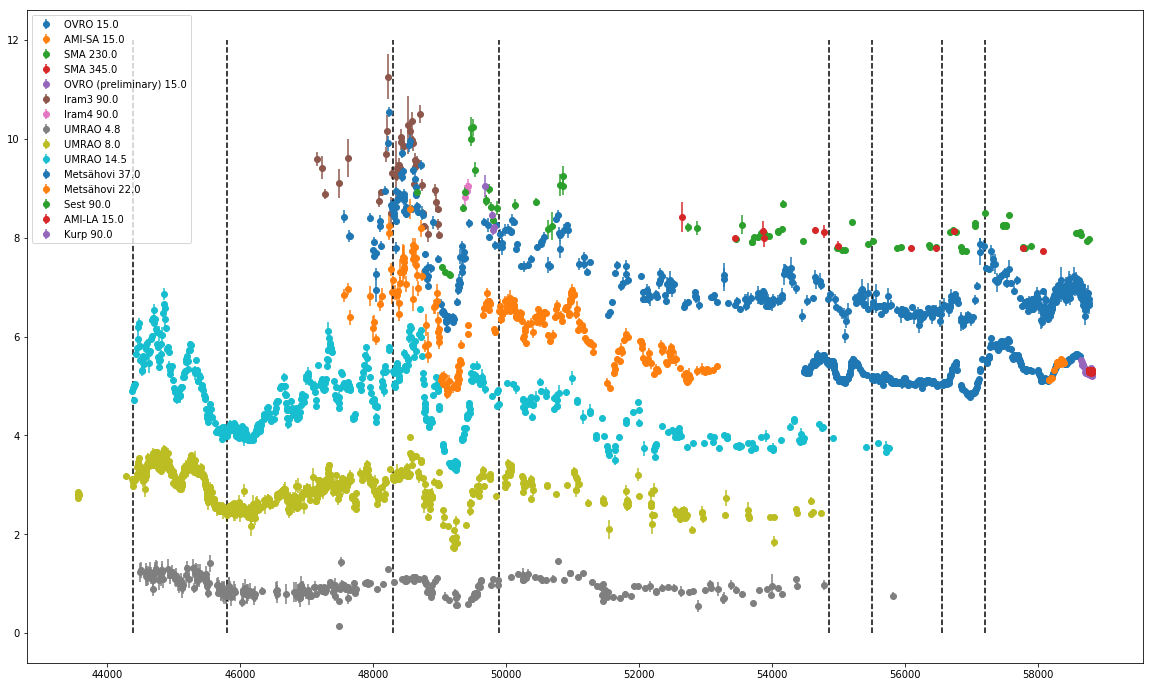

In [47]:
MIN_DAY1 = 44400
MAX_DAY1 = 45800
MIN_DAY2 = 48300
MAX_DAY2 = 49900

MIN_DAY3 = 54860
MAX_DAY3 = 55500
MIN_DAY4 = 56550
MAX_DAY4 = 57200

plt.figure(figsize=(20,12))
for i, title in enumerate(titles):
#     plt.subplot(15,1,i+1)
    plt.errorbar(Days[i],Fluxes[i] + offsets["{} {}".format(title[0],title[1])],yerr=Flux_errs[i],
                 fmt='o', label="{} {}".format(title[0],title[1]))
#     plt.title("Obs = {}, freq = {}".format(title[0],title[1]))
plt.legend()
plt.plot([MIN_DAY1,MIN_DAY1],[0,12],'k--')
plt.plot([MAX_DAY1,MAX_DAY1],[0,12],'k--')

plt.plot([MIN_DAY2,MIN_DAY2],[0,12],'k--')
plt.plot([MAX_DAY2,MAX_DAY2],[0,12],'k--')

plt.plot([MIN_DAY3,MIN_DAY3],[0,12],'k--')
plt.plot([MAX_DAY3,MAX_DAY3],[0,12],'k--')

plt.plot([MIN_DAY4,MIN_DAY4],[0,12],'k--')
plt.plot([MAX_DAY4,MAX_DAY4],[0,12],'k--')

First try fitting SAV2 across all relevant bands:
- UMRAO 4.8
- UMRAO 8.0
- UMRAO 14.5
- Metsahovi 22
- Metsahovi 37
- Sest 90, Iram3 90, Iram4 90, Kurp 90


In [2]:
with open('/home/users/alpv95/khome/Yannis/chains22/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/Yannis/chains22/3-" + '_1_', n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']


11
  analysing data from /home/users/alpv95/khome/Yannis/chains22/3-_1_.txt
{'log_likelihood': -6266.3023098781405, 'parameters': [44738.73302381242, 0.14386144623508823, 2168.5183467588636, 0.7050967616274801, 0.09624210608866386, 97.17709413599623, 0.04828971338304181, 49185.670234974845, 0.031322330108311036, 2814.540115991642, 58.6148643204336]}


creating marginal plot ...


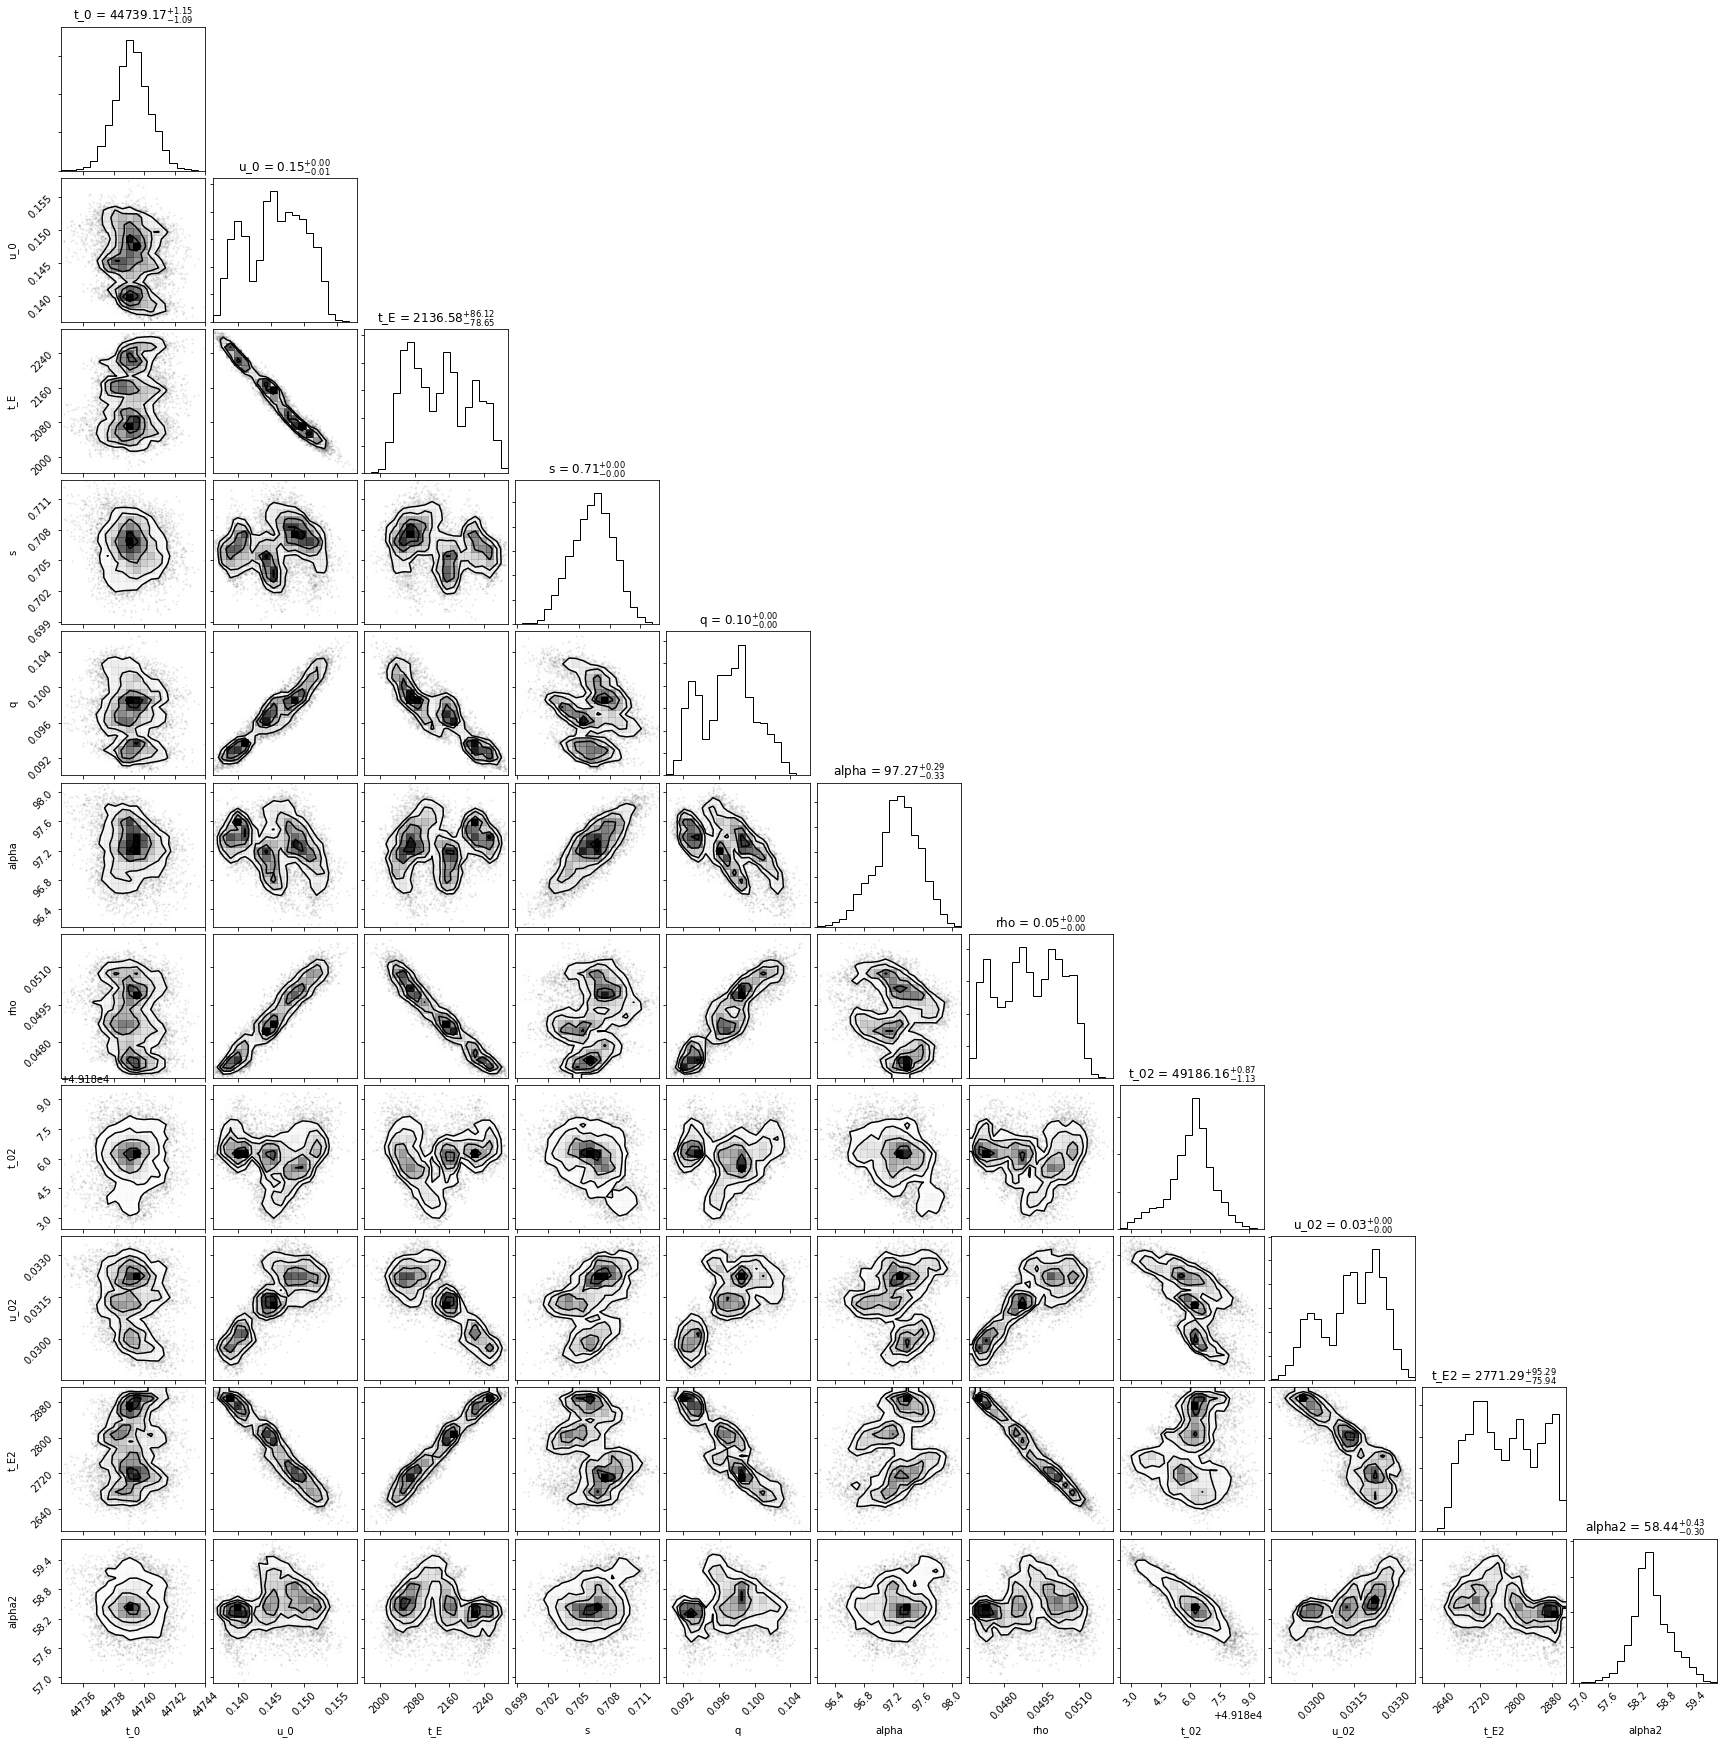

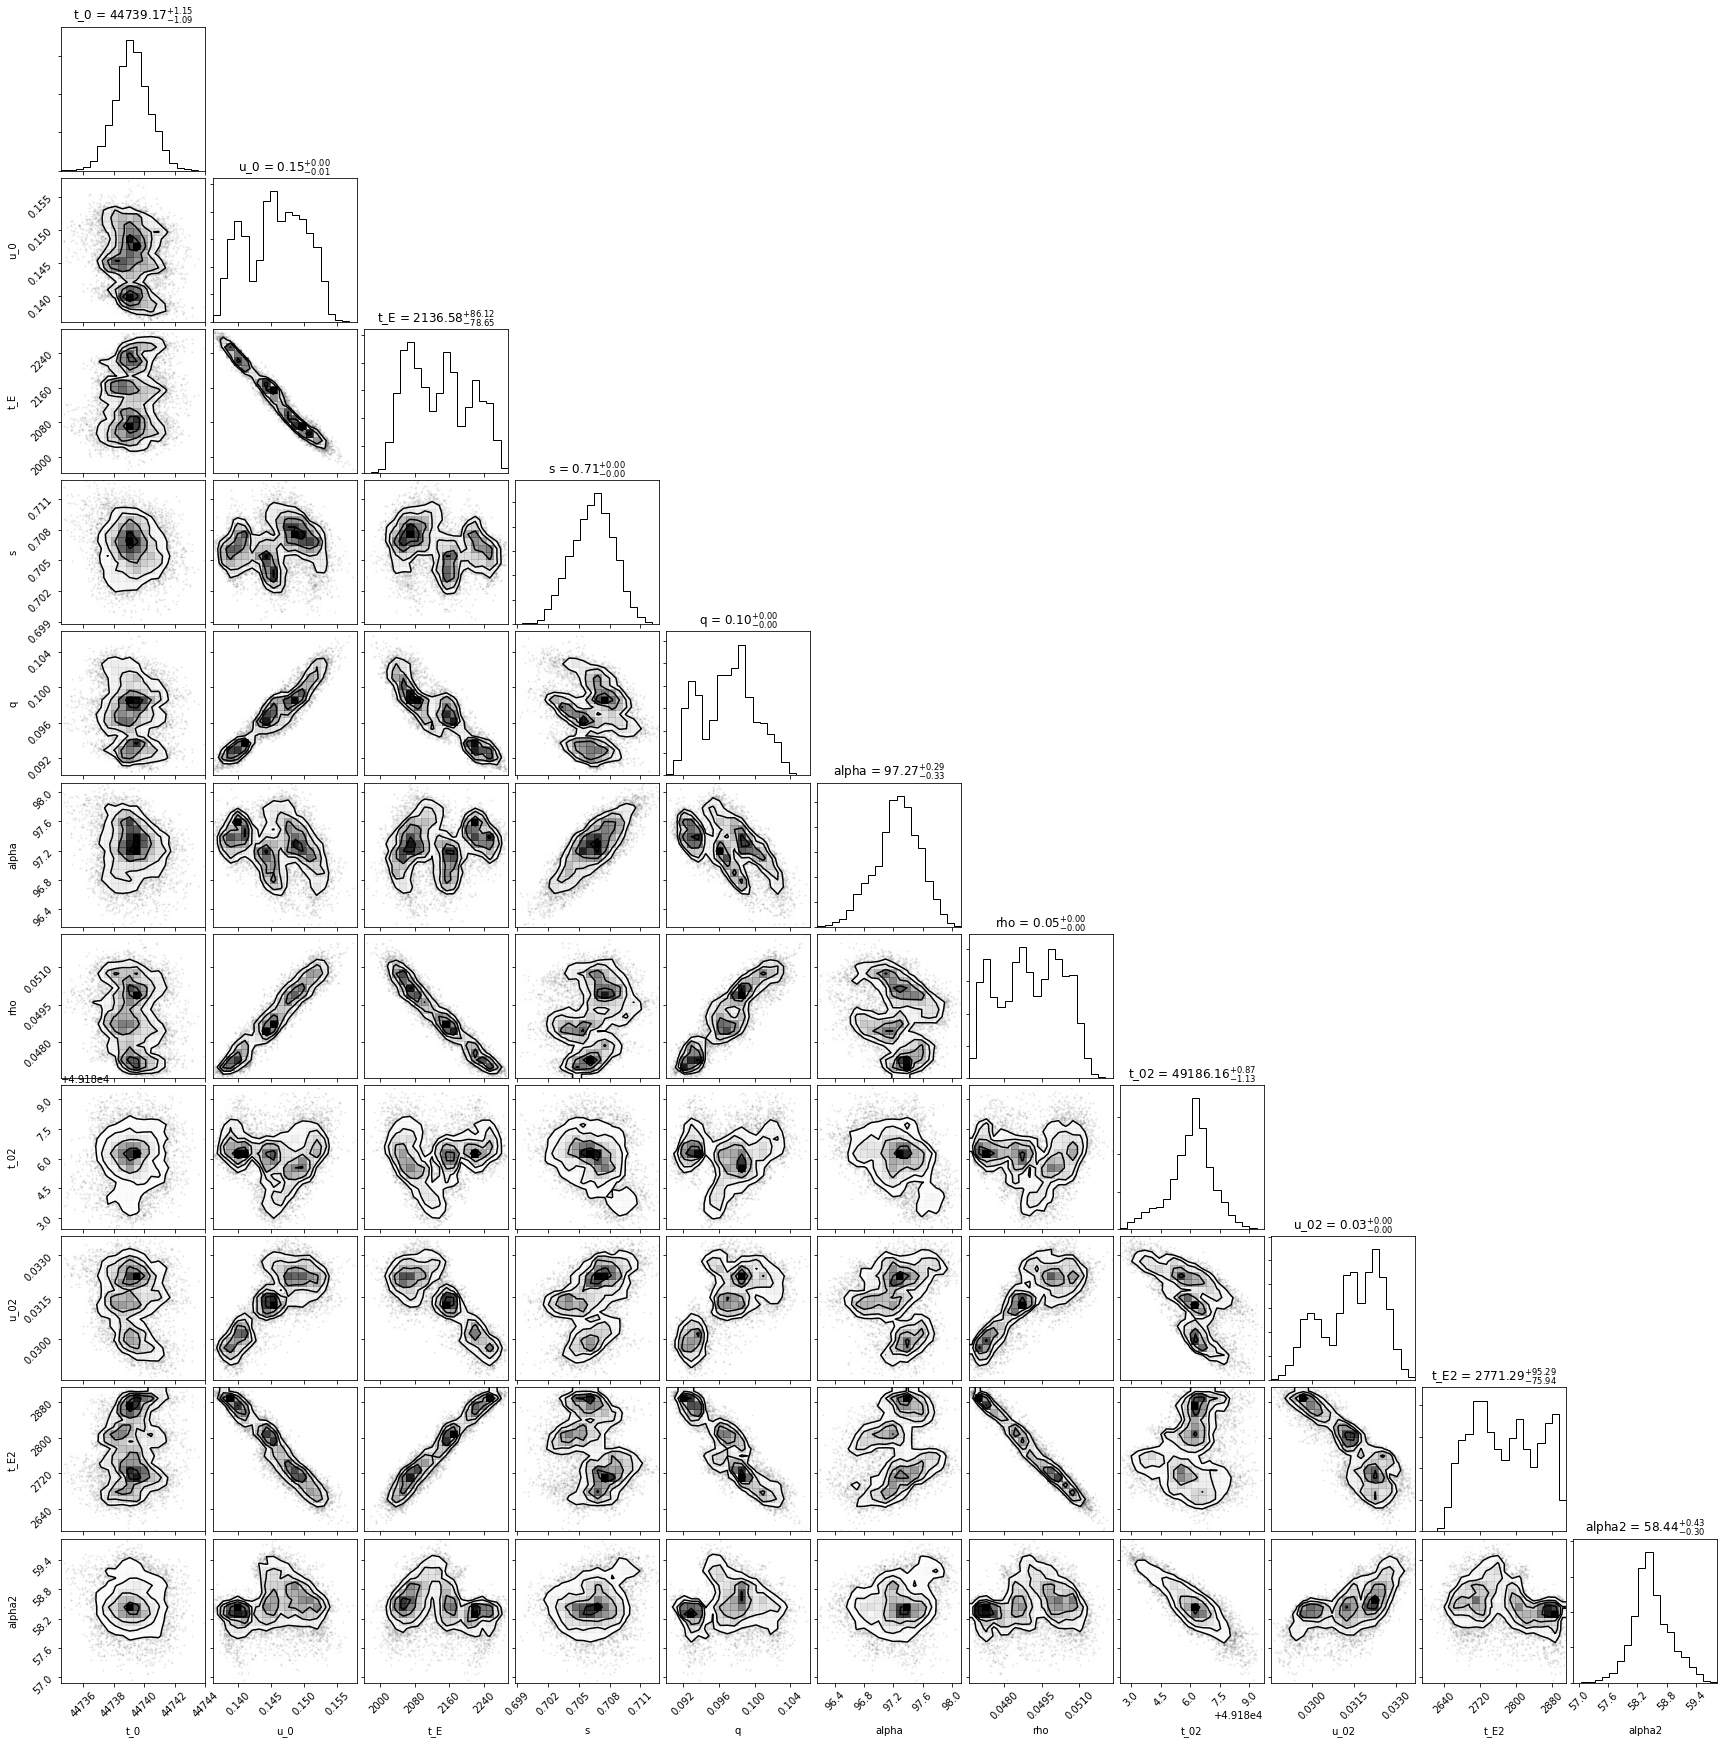

In [8]:
print('creating marginal plot ...')
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]
#mask = weights.cumsum() > 1e-5
mask = weights > 5e-5
corner.corner(data[mask,:], weights=weights[mask],
labels=parameters, show_titles=True, title_fmt=".2f",)

In [31]:
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def create_lens(Day, t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021):
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha,
         'rho': rho})
    lens.set_magnification_methods([min(Day), 'VBBL', max(Day)])  
    
    return lens

def QPsolver(data, prediction, lower, upper):
    _, Flux, Flux_err = data

    m = len(Flux); n = 2 #dimensions
    w = np.diag(1 / Flux_err)
    Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in prediction], axis=0))
    Ad = sparse.csc_matrix(Ad)
    b = np.matmul(w, Flux)
    constraint_M = np.array([[1, 1], [1, 0]])

    # OSQP data
    P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
    Q = np.zeros(n + m)
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
    l = np.hstack([b, lower, 1e-4])
    u = np.hstack([b, upper, np.inf])

    with nostdout():
        # Create an OSQP object
        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(P, Q, A, l, u, eps_rel=0.0001,polish=1)
        # Solve problem
        res = prob.solve()

    return res.x[:2], res.info.obj_val #flux_scale and loss

0.11007316297230221 9.999999916511949e-05
0.11229117065678536 9.999999919320496e-05
0.1061845218400678 9.999999905536024e-05
0.11279895289246585 9.999999913665997e-05
0.1150681570866203 9.999999917962924e-05
0.1071058775035682 9.999999904452957e-05
0.10599771393884737 9.999999898533273e-05
0.10725019949775816 9.999999901774149e-05
0.11332434116153794 9.999999916205011e-05
0.1048262624425083 9.999999897289319e-05
0.11109285810227239 9.999999911747365e-05
0.3077894220302162 9.999999938937071e-05
0.3143290711671399 9.999999940959871e-05
0.2965743775796604 9.999999930636295e-05
0.3140444873121955 9.999999936459865e-05
0.32125969070151666 9.999999939485317e-05
0.2986644410328831 9.999999929821016e-05
0.2954278351814343 9.999999924915273e-05
0.2990074612352095 9.999999927782127e-05
0.3163974285859641 9.999999938150624e-05
0.29269296603720524 9.99999992419235e-05
0.30985878624945196 9.99999993526307e-05
0.6533882288556496 9.999999363621195e-05
0.6663159754811936 9.999999392460689e-05
0.630576

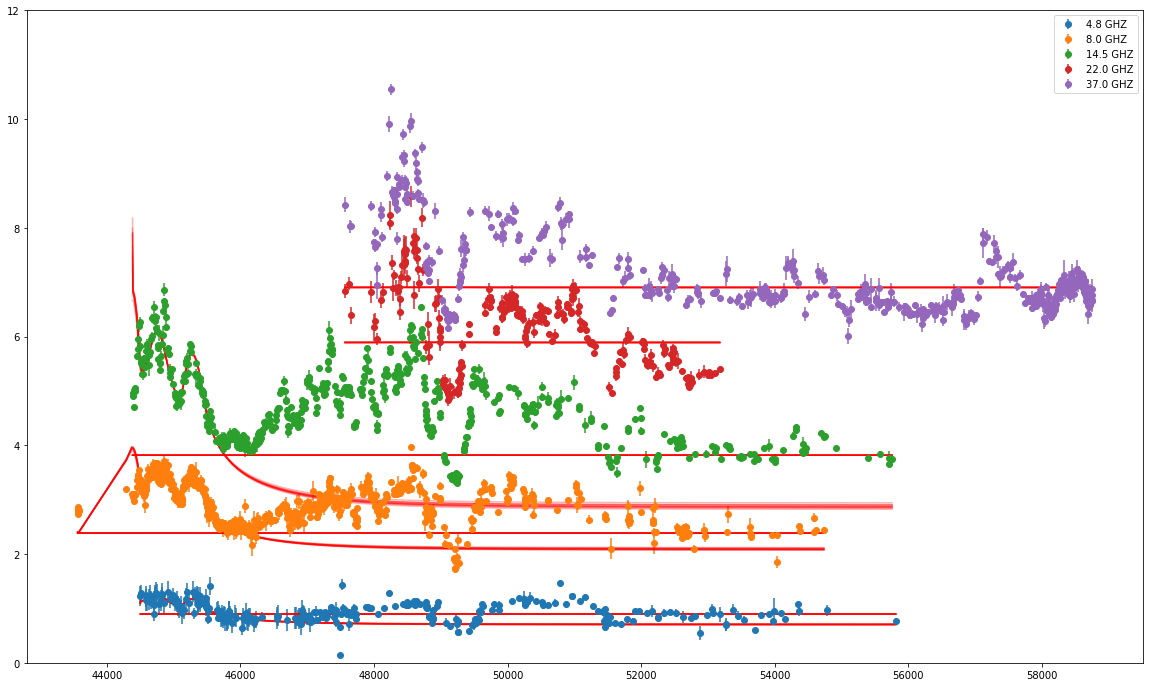

In [32]:
MIN_DAY1 = 44500
MAX_DAY1 = 45750
MIN_DAY2 = 48890
MAX_DAY2 = 49800

Y = pd.read_csv("/home/users/alpv95/khome/Yannis/data/PKS1413_135_all.dat", delimiter=",")

freqs = [4.8,8.0,14.5,22.0,37.0]
offsets = {4.8: 0, 8.0: 1.5, 14.5: 3, 15.0: 4.5,
          22.0: 4.5, 37.0: 6.0, 230.0: 7.5, 345.0: 7.5,
           90.0: 7,}

Data1 = {}
Data2 = {}
Data_plot = {}
for freq in freqs:
    Day1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' MJD']
    Flux1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' Flux (Jy)']
    Flux_err1 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY1) & (Y[' MJD'] > MIN_DAY1)][' Fluxerr (Jy)']

    Day2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' MJD']
    Flux2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' Flux (Jy)']
    Flux_err2 = Y.loc[(Y[' Frequency (GHz)'] == freq) & (Y[' MJD'] < MAX_DAY2) & (Y[' MJD'] > MIN_DAY2)][' Fluxerr (Jy)']

    Dayp = Y.loc[Y[' Frequency (GHz)'] == freq][' MJD']
    Fluxp = Y.loc[Y[' Frequency (GHz)'] == freq][' Flux (Jy)']
    Flux_errp = Y.loc[Y[' Frequency (GHz)'] == freq][' Fluxerr (Jy)']

    if not Dayp.empty:
        Data1[freq] = ( Day1.to_numpy(),Flux1.to_numpy(), Flux_err1.to_numpy() )
        Data2[freq] = ( Day2.to_numpy(), Flux2.to_numpy(), Flux_err2.to_numpy() )
        Data_plot[freq] = (Dayp.to_numpy(), Fluxp.to_numpy(), Flux_errp.to_numpy())
        
plt.figure(figsize=(20,12))
plt.ylim(ymin=0,ymax=12)
for i, freq in enumerate(freqs):
    Day, Flux, Flux_err = Data_plot[freq]
    plt.errorbar(Day,Flux + offsets[freq],yerr=Flux_err,
                 fmt='o', label="{} GHZ".format(freq))
    lower = np.min(Flux) - np.std(Flux); upper = np.max(Flux) + np.std(Flux)
    for (t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) in a.get_equal_weighted_posterior()[::1000, :-1]:
        Day1, _, _ = Data1[freq]
        Day2, _, _ = Data2[freq]
        if Day1.size:
            lens1 = create_lens(Day1, t_0, u_0, t_E, s, q, alpha, rho)
            p_hat1 = lens1.magnification(Day1)
            flux_scale1, _ = QPsolver(Data1[freq], p_hat1, lower, upper)

            lens1 = create_lens(Day, t_0, u_0, t_E, s, q, alpha, rho)
            p_hat_plot = lens1.magnification(Day)
            plt.plot(Day, flux_scale1[0] * p_hat_plot + flux_scale1[1] + offsets[freq], alpha=0.3, color='r')

        if Day2.size:
            lens2 = create_lens(Day2, t_02, u_02, t_E2, s, q, alpha2, rho)
            p_hat2 = lens2.magnification(Day2)
            flux_scale2, _ = QPsolver(Data2[freq], p_hat2, lower, upper)

            lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2, rho)
            p_hat_plot = lens2.magnification(Day)
            plt.plot(Day, flux_scale2[0] * p_hat_plot + flux_scale2[1] + offsets[freq], alpha=0.3, color='r')
        print(flux_scale1[0],flux_scale2[0])
plt.legend()

In [114]:
freq = 14.5
Day, Flux, Flux_err = Data_plot[freq]
lower = np.min(Flux)
upper = np.max(Flux)

(t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) = result
Day2, Flux2, Flux_err2 = Data2[freq]
lens2 = create_lens(Day2, t_02, u_02, t_E2, s, q, alpha2, rho)
p_hat2 = lens2.magnification(Day2)

# Generate problem data
m = len(Flux2)
n = 2
#Ad = sparse.random(m, n, density=0.7, format='csc')
w = np.diag(1 / Flux_err2)
Ad = np.matmul(w, np.concatenate([np.array([[p, 1]]) for p in p_hat2], axis=0))
Ad = sparse.csc_matrix(Ad)
b = np.matmul(w,Flux2)
constraint_M = np.array([[1, 1],[1, 0]])

# OSQP data
P = sparse.block_diag([sparse.csc_matrix((n, n)), sparse.eye(m)], format='csc')
Q = np.zeros(n+m)
A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.csc_matrix(constraint_M), sparse.csc_matrix((n, m))])], format='csc')
l = np.hstack([b, lower, -np.inf])
u = np.hstack([b, upper, 0])

# Create an OSQP object
prob = osqp.OSQP()

with nostdout():
    # Setup workspace
    prob.setup(P, Q, A, l, u)
    
    # Solve problem
    res = prob.solve()

In [108]:
res.info.obj_val

15951.658358507946

In [98]:
flux_scale2 = res.x[:2]

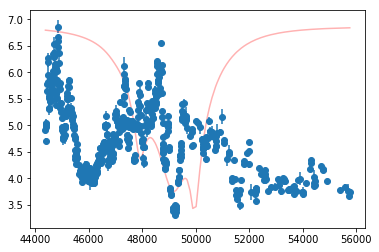

In [99]:
lens2 = create_lens(Day, t_02, u_02, t_E2, s, q, alpha2, rho)
p_hat_plot = lens2.magnification(Day)

plt.errorbar(Day,Flux + offsets[freq],yerr=Flux_err,
                 fmt='o', label="{} GHZ".format(freq))
plt.plot(Day, flux_scale2[0] * p_hat_plot + flux_scale2[1] + offsets[freq], alpha=0.3, color='r')

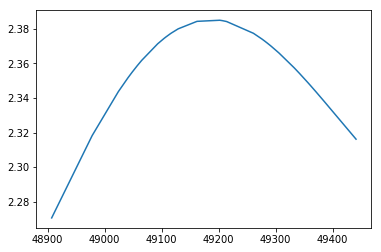

In [58]:
plt.plot(Day2,p_hat2)

<Container object of 3 artists>

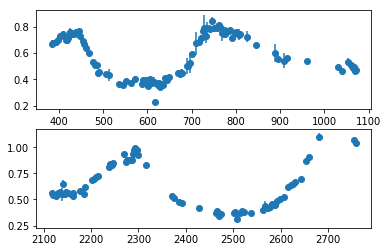

In [3]:
X = np.loadtxt("/home/users/alpv95/khome/Yannis/data/data_tofit.csv",delimiter=',')
Day = X[:,0]
Flux = X[:,1]
Flux_err = X[:,2]

Day1 = X[49:152,0] #[49:152] [40:152]
Flux1 = X[49:152,1]
Flux_err1 = X[49:152,2]

plt.subplot(211)
plt.errorbar(Day1,Flux1,yerr=Flux_err1,fmt="o")

Day2 = X[290:362,0] #[290:361] 290:362
Flux2 = X[290:362,1]
Flux_err2 = X[290:362,2]

plt.subplot(212)
plt.errorbar(Day2,Flux2,yerr=Flux_err2,fmt="o")

In [4]:
def create_lens(t_0=0.5,u_0=-0.2,t_E=1.0,s=1.0,q=0.01,alpha=270,rho=0.021,ds_dt=0,dalpha_dt=0):
    # Create a PSPL model
    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha,
         'rho': rho,'ds_dt':ds_dt, 'dalpha_dt': dalpha_dt})
    lens.set_magnification_methods([min(Day), 'VBBL', max(Day)])
    
    return lens
    
def normalize_data(lightcurve):
    lightcurve[:,0] = (lightcurve[:,0] - np.min(lightcurve[:,0])) / (np.max(lightcurve[:,0]) - np.min(lightcurve[:,0]))
    lightcurve[:,1] = (lightcurve[:,1] - np.min(lightcurve[:,1])) / (np.max(lightcurve[:,1]) - np.min(lightcurve[:,1]))
    return lightcurve

<Container object of 3 artists>

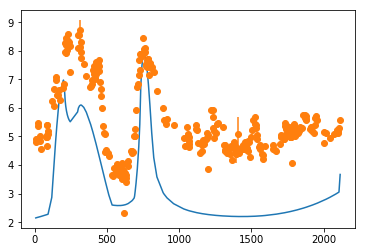

In [31]:
lens, lens2 = create_lens(t_0=446.6580144973914,u_0=-0.1809695283892867,t_E=1267.6154050685568,s=0.8028855935030114,q=0.2916910349903737,alpha=34.96229255002339,rho=0.022690101950104014,ds_dt=0)
plt.plot(Day,0.5*lens.magnification(Day) + lens2.magnification(Day) )
plt.errorbar(Day,10*Flux,yerr=Flux_err,fmt="o")


Text(0.5,1,'Source Trajectory')

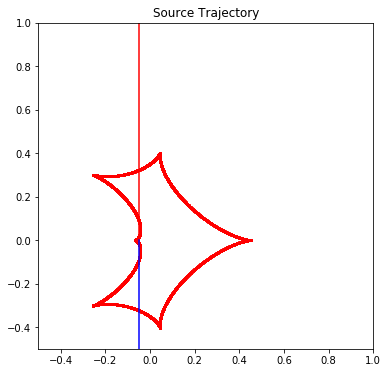

In [5]:
plt.figure(figsize=(6, 6))
t_0=1500; t_E=1500;
lens.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
lens.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.xlim(-0.5, 1.0)
plt.ylim(-0.5, 1.0)
plt.title('Source Trajectory')

In [6]:
def prior(cube, ndim, nparams):
    #t_0=0.5,u_0=-0.18,t_E=0.5,s=1,q=0.1,alpha=270,rho=0.01
    cube[0] = cube[0] * (max(Day) - min(Day)) + min(Day)
    cube[1] = cube[1]*0.8 - 0.4
    cube[2] = cube[2] * (max(Day) - min(Day)) + (max(Day) - min(Day))/4 #offset
    cube[3] = cube[3] * 0.4 + 0.8
    cube[4] = cube[4] * 0.4 + 0.01
    cube[5] = cube[5] * 360
    cube[6] = 10**(cube[6]*4 - 5) #flux_offset
    return cube

In [7]:
def loglike(cube, ndim, nparams):
    t_0, u_0, t_E, s, q, alpha, rho = cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6]
    lens = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
    p_hat = lens.magnification(Day)
    #Do linear regression to find optimal axis value here

    A = np.concatenate([np.array([[p,1]]) for p in p_hat],axis=0)
    w = np.diag(1 / Flux_err)
    b = Flux
    flux_scale, loss_flux, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))

    return -loss_flux 

In [8]:
try: os.mkdir('chains')
except OSError: pass

In [18]:
with open('/home/users/alpv95/khome/Yannis/chains3/3-_1_params.json') as json_file:
    parameters = json.load(json_file)
n_params = len(parameters)
print(n_params)
a = pymultinest.Analyzer(outputfiles_basename="/home/users/alpv95/khome/Yannis/chains3/3-" + '_1_', n_params = n_params)
print(a.get_best_fit())
result = a.get_best_fit()['parameters']



11
  analysing data from /home/users/alpv95/khome/Yannis/chains3/3-_1_.txt
{'log_likelihood': -9.973014673293484, 'parameters': [925.9799786886877, 0.21919076797284853, 1407.5551554413069, 0.9741548196332227, 0.6831904175335324, 209.60040944093586, 0.028138878777743744, 2738.7571292859643, -0.2089969709502533, 1916.711050442986, 321.06045323653893]}


In [56]:
1916/365

5.249315068493151

In [5]:
a.get_equal_weighted_posterior()[-1,:-1]

array([ 9.19312534e+02,  1.48511977e-01,  1.90628903e+03,  7.89803810e-01,
        2.60505761e-01,  1.19178740e+02,  3.22720063e-02,  2.40200851e+03,
       -1.42719024e-01,  1.98980985e+03,  2.98921572e+02])

In [22]:
S = []
Q = []
for (t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) in a.get_equal_weighted_posterior()[::2,:-1]:
    S.append(s)
    Q.append(q)

Text(0,0.5,'q')

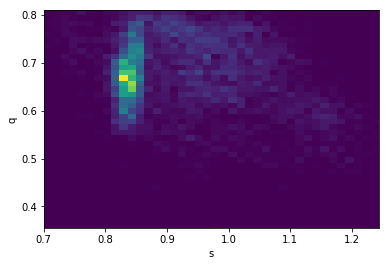

In [52]:
plt.hist2d(S,Q, bins=40,)
plt.xlabel("s")
plt.ylabel("q")

(array([0.07532382, 0.18292927, 0.69943545, 0.93616745, 0.98997018,
        0.90388582, 0.85008309, 0.76399873, 0.64563273, 0.83932255,
        1.14061782, 1.11909673, 0.75323818, 0.79628036, 0.78551982,
        0.67791436, 0.50574564, 0.38737964, 0.710196  , 1.420392  ,
        2.17363018, 3.42185346, 4.67007673, 4.47638691, 4.64855564,
        3.72314873, 3.68010655, 3.06675546, 2.76546018, 2.92686836,
        2.49644655, 1.99070091, 1.92613764, 1.76472946, 1.538758  ,
        1.15137836, 0.44118236, 0.08608436, 0.07532382, 0.02152109]),
 array([0.60928198, 0.62535186, 0.64142173, 0.65749161, 0.67356149,
        0.68963136, 0.70570124, 0.72177111, 0.73784099, 0.75391087,
        0.76998074, 0.78605062, 0.80212049, 0.81819037, 0.83426024,
        0.85033012, 0.8664    , 0.88246987, 0.89853975, 0.91460962,
        0.9306795 , 0.94674938, 0.96281925, 0.97888913, 0.994959  ,
        1.01102888, 1.02709875, 1.04316863, 1.05923851, 1.07530838,
        1.09137826, 1.10744813, 1.12351801, 1.

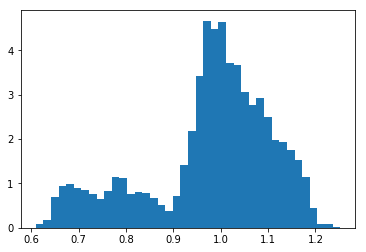

In [23]:
plt.hist(S, bins=40,density=True)

/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/users/alpv95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[14.0710857] [12.9948037]
[6.54899525] [11.3968793]
[5.98086775] [12.75477238]
[7.32688285] [8.19419836]
[6.87072692] [9.07446902]
[5.16054682] [9.50383518]
[4.6919129] [9.66595276]
[4.43970462] [8.45787077]
[4.0408316] [10.68316819]
[4.72264473] [7.85138659]
[3.7559789] [7.96379944]
[3.96901738] [6.97644581]


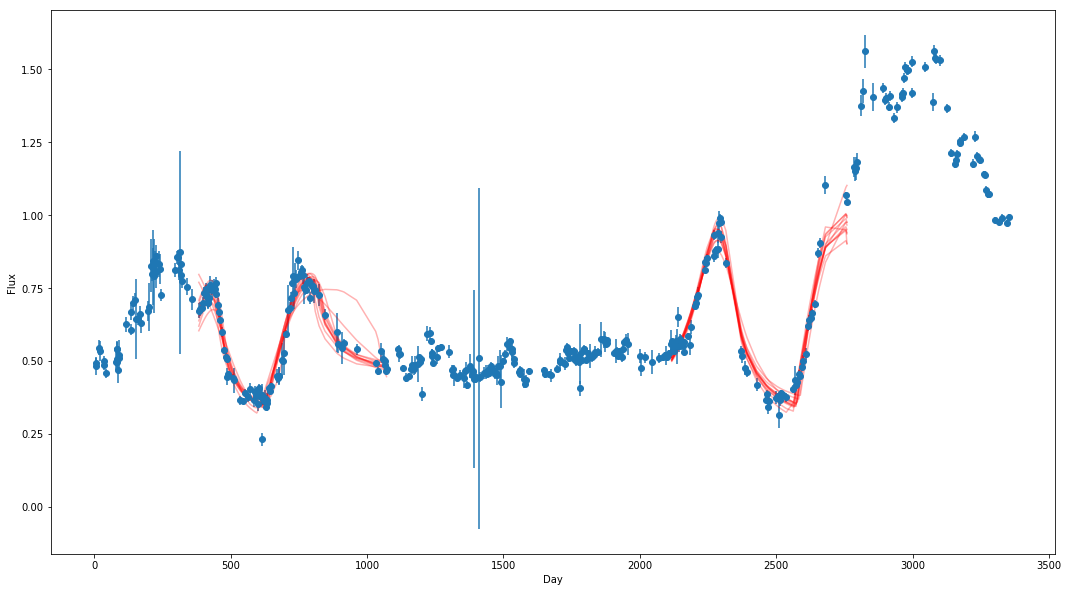

In [27]:
plt.figure(figsize=(18,10))
#plt.subplot(211)
plt.errorbar(Day,Flux,yerr=Flux_err,fmt="o")
plt.xlabel("Day")
plt.ylabel("Flux")

for (t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2) in a.get_equal_weighted_posterior()[::1000,:-1]:
    
    #t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2 = result
    lens1 = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
    lens2 = create_lens(t_02, u_02, t_E2, s, q, alpha2, rho)
    p_hat1 = lens1.magnification(Day1) 
    p_hat2 = lens2.magnification(Day2)
    #Do linear regression to find optimal axis value here

    A = np.concatenate([np.array([[p,1]]) for p in p_hat1],axis=0)
    w = np.diag(1 / Flux_err1)
    b = Flux1
    flux_scale1, loss_flux1, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    plt.plot(Day1,flux_scale1[0]*p_hat1 + flux_scale1[1], alpha=0.3,color='r')
    
    A = np.concatenate([np.array([[p,1]]) for p in p_hat2],axis=0)
    w = np.diag(1 / Flux_err2)
    b = Flux2
    flux_scale2, loss_flux2, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
    plt.plot(Day2,flux_scale2[0]*p_hat2 + flux_scale2[1], alpha=0.3,color='r')
    print(loss_flux1 / len(Day1),loss_flux2 / len(Day2))
    
    
# plt.subplot(212)
# plt.plot([400,2700],[0,0],"--")

# t_0, u_0, t_E, s, q, alpha, rho, t_02, u_02, t_E2, alpha2 = result
# lens1 = create_lens(t_0, u_0, t_E, s, q, alpha, rho)
# lens2 = create_lens(t_02, u_02, t_E2, s, q, alpha2, rho)
# p_hat1 = lens1.magnification(Day1) 
# p_hat2 = lens2.magnification(Day2)
# #Do linear regression to find optimal axis value here

# A = np.concatenate([np.array([[p,1]]) for p in p_hat1],axis=0)
# w = np.diag(1 / Flux_err1)
# b = Flux1
# flux_scale1, loss_flux1, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
# plt.plot(Day1,flux_scale1[0]*p_hat1 + flux_scale1[1] - Flux1, color='r')

# A = np.concatenate([np.array([[p,1]]) for p in p_hat2],axis=0)
# w = np.diag(1 / Flux_err2)
# b = Flux2
# flux_scale2, loss_flux2, _, _ = np.linalg.lstsq(np.matmul(w,A),np.matmul(w,b))
# plt.plot(Day2,flux_scale2[0]*p_hat2 + flux_scale2[1] - Flux2, color='r')
# print(loss_flux1 / len(Day1),loss_flux2 / len(Day2))

    

  marginal likelihood:
    ln Z = -46.9 +- 0.3
  parameters:
    t_0            922 +- 105
    u_0            0.233 +- 0.051
    t_E            1401 +- 284
    s              1.00 +- 0.14
    q              0.654 +- 0.088
    alpha          210 +- 79
    rho            0.036 +- 0.015
    t_02           2675 +- 137
    u_02           -0.23 +- 0.25
    t_E2           1630 +- 223
    alpha2         316 +- 132
creating marginal plot ...


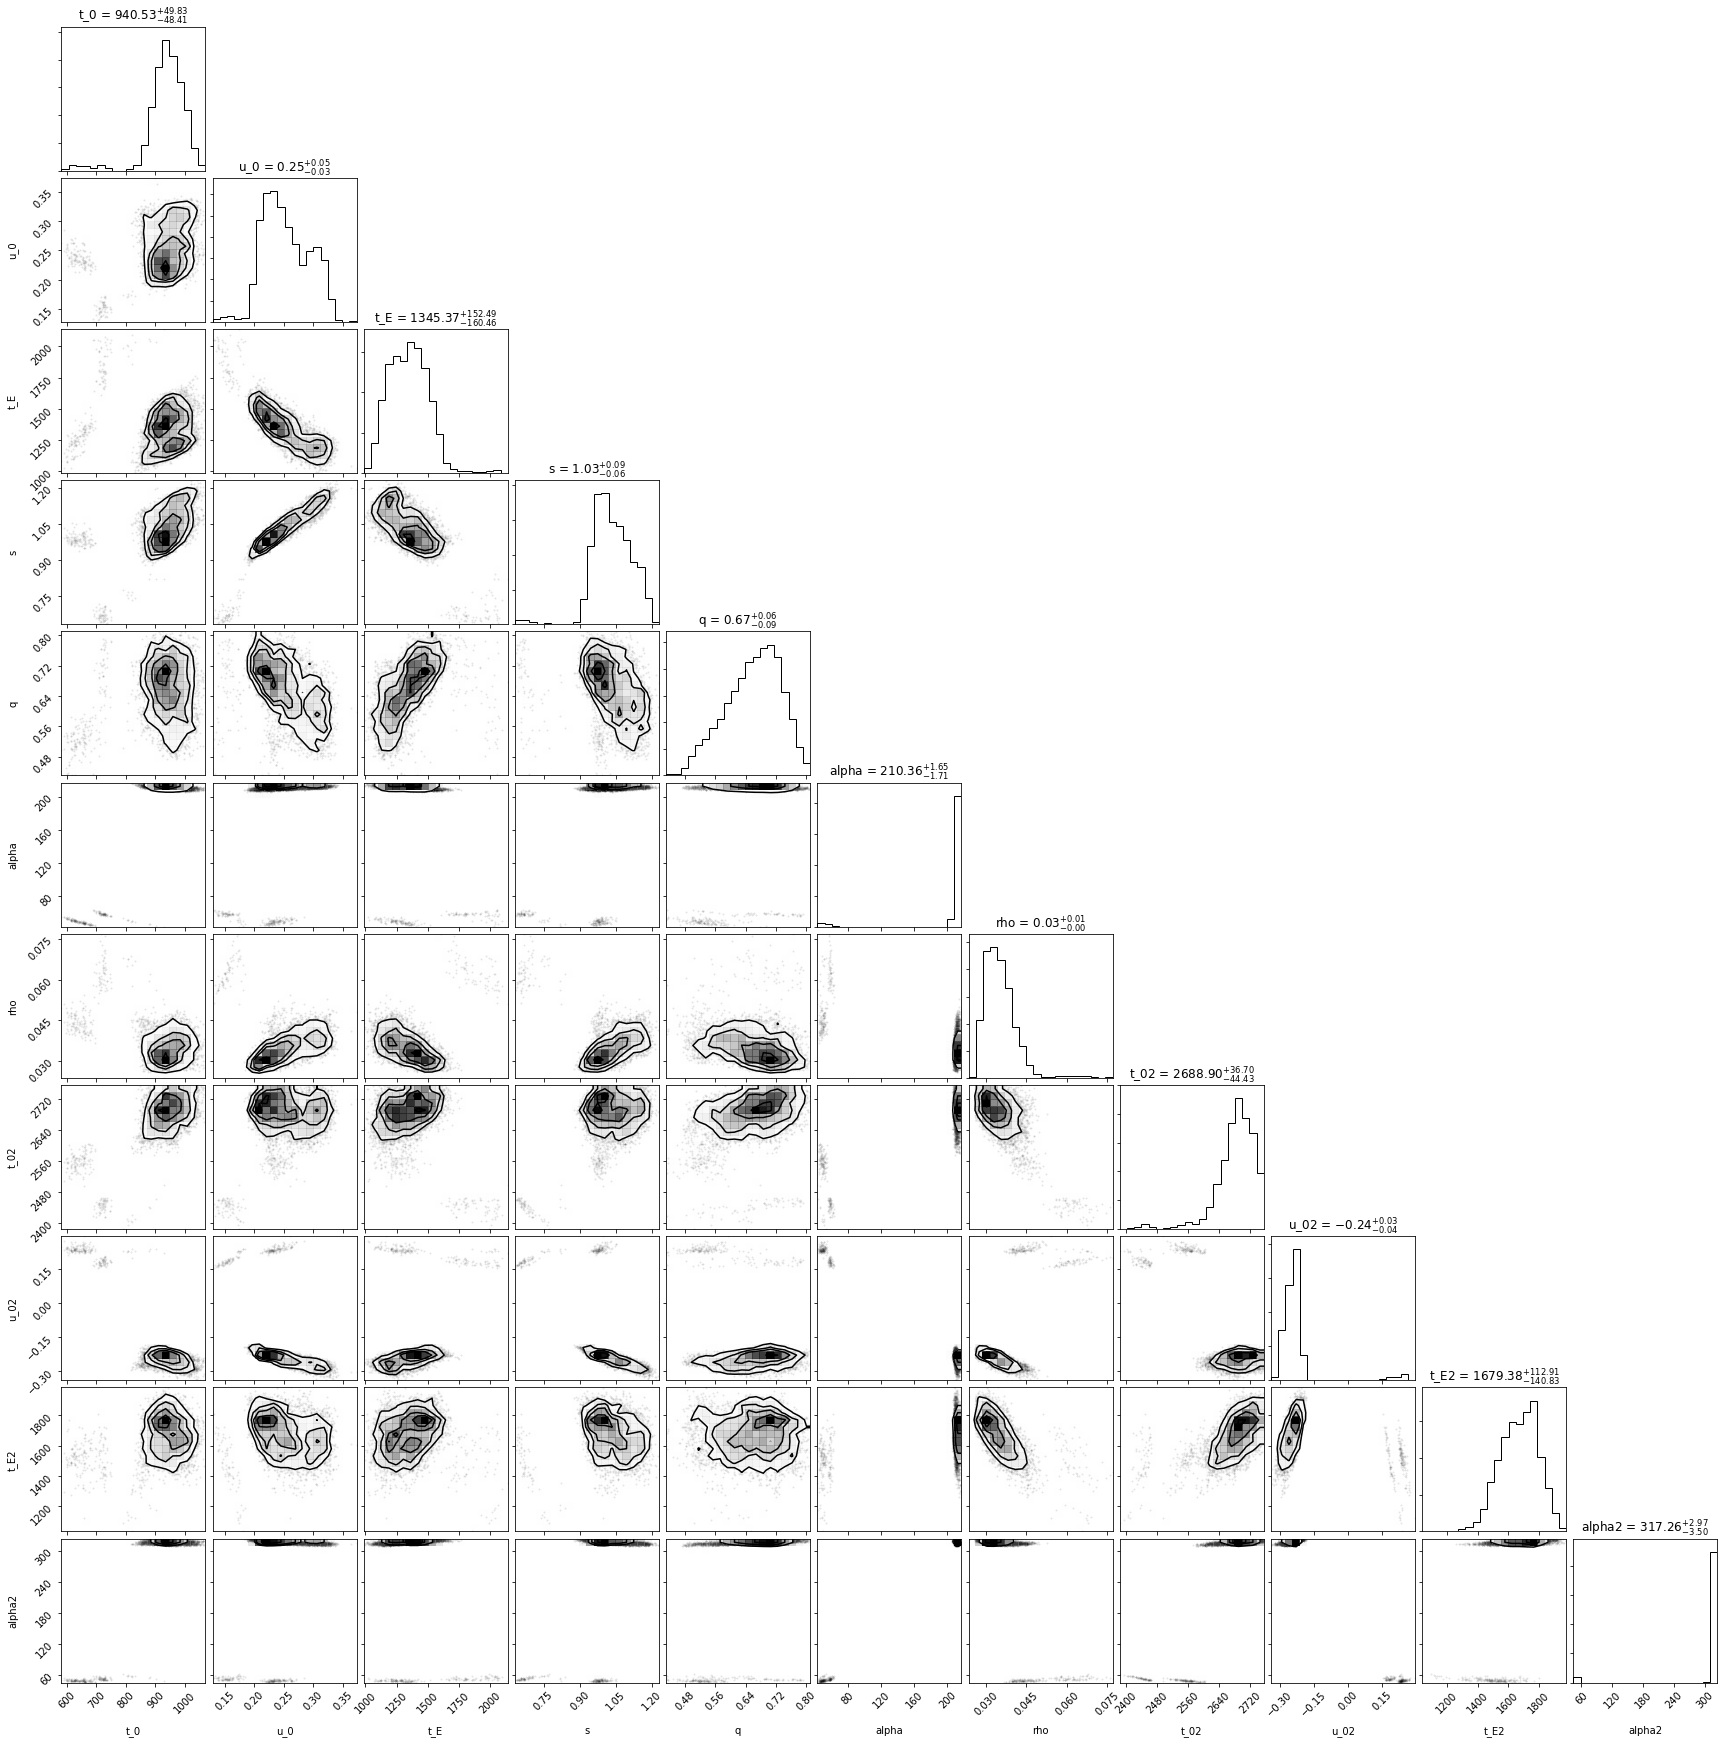

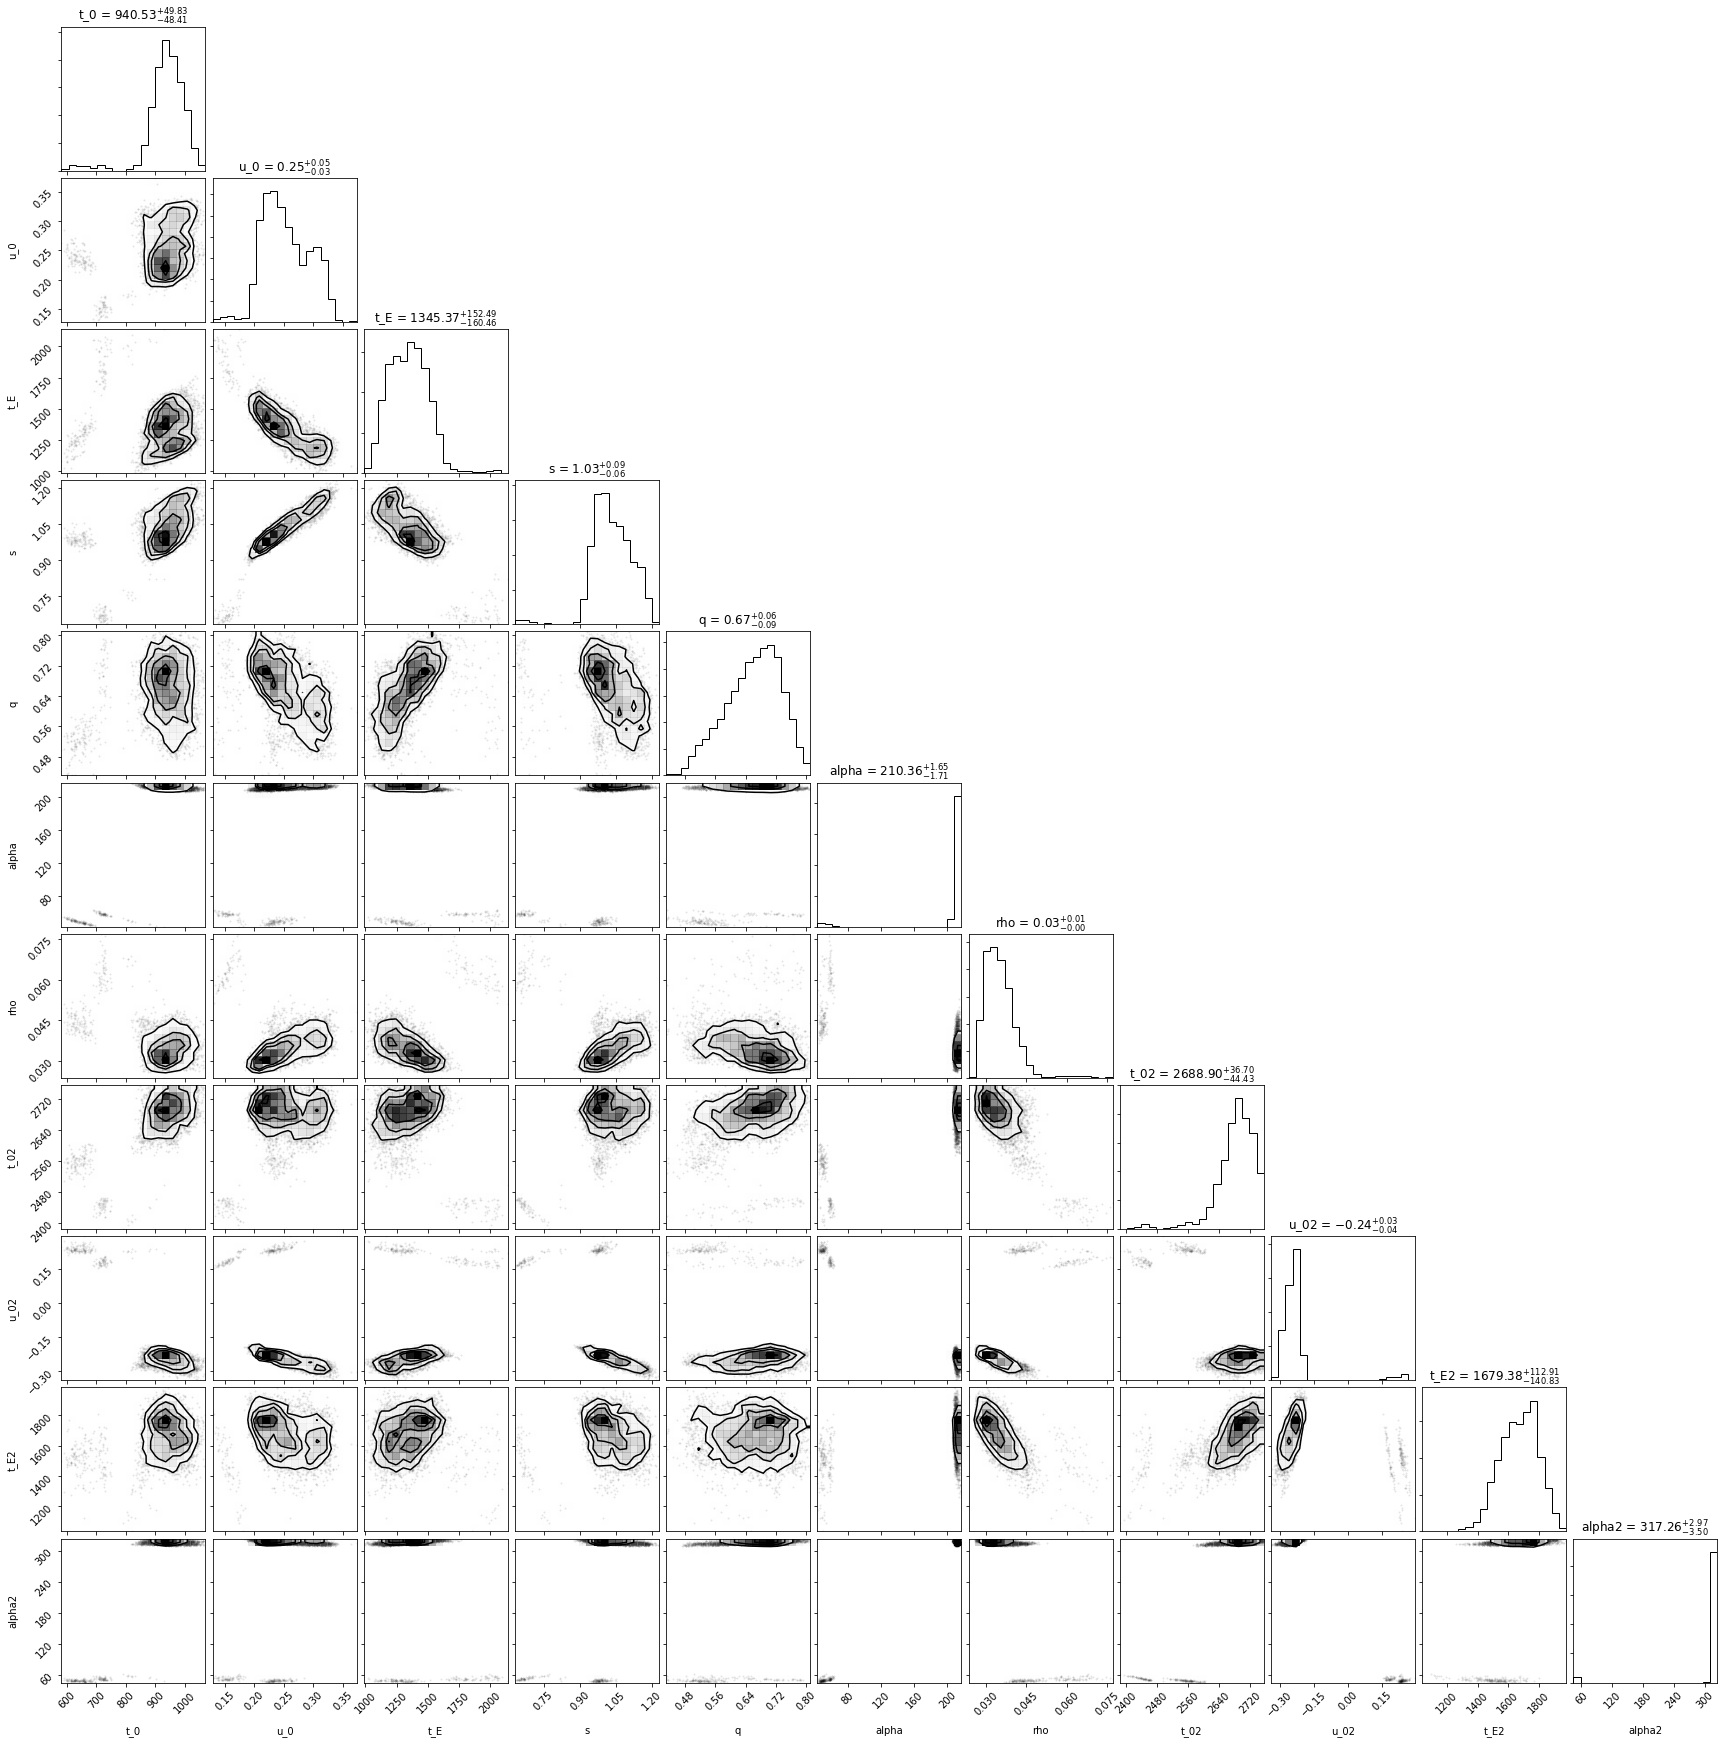

In [21]:
# if len(sys.argv) != 2:
#         sys.stderr.write("""SYNOPSIS: %s <output-root>
#         output-root:     Where the output of a MultiNest run has been written to.
#                           Example: chains/1-
# %s""" % (sys.argv[0], __doc__))
#         sys.exit(1)

# prefix = sys.argv[1]
# print('model "%s"' % prefix)
# if not os.path.exists(prefix + 'params.json'):
#         sys.stderr.write("""Expected the file %sparams.json with the parameter names.
# For example, for a three-dimensional problem:
# ["Redshift $z$", "my parameter 2", "A"]
# %s""" % (sys.argv[1], __doc__))
#         sys.exit(2)

s = a.get_stats()

#json.dump(s, open(prefix + 'stats.json', 'w'), indent=4)

print('  marginal likelihood:')
print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
print('  parameters:')
for p, m in zip(parameters, s['marginals']):
        lo, hi = m['1sigma']
        med = m['median']
        sigma = (hi - lo) / 2
        if sigma == 0:
                i = 3
        else:
                i = max(0, int(-np.floor(np.log10(sigma))) + 1)
        fmt = '%%.%df' % i
        fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
        print(fmts % (p, med, sigma))

print('creating marginal plot ...')
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]

#mask = weights.cumsum() > 1e-5
mask = weights > 1e-4

corner.corner(data[mask,:], weights=weights[mask],
        labels=parameters, show_titles=True, title_fmt=".2f",)
# plt.savefig(prefix + 'corner.pdf')
# plt.savefig(prefix + 'corner.png')
# plt.close()

In [8]:
print( s, q, C)

1.2462841970201115 0.2922887232578552 0.6125448255826218


<Container object of 3 artists>

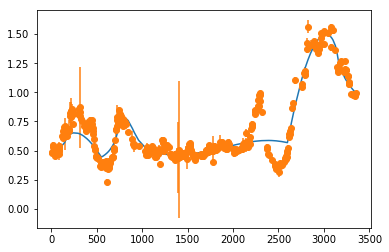

In [41]:
plt.plot(Day,flux_scale[0]*p_hat + flux_scale[1])
plt.errorbar(Day,Flux,yerr=Flux_err,fmt="o")